In [1]:
import sys
sys.path.append('../')

In [2]:
from typing import List
from collections import Counter

def raw_majority_vote(labels: List[str]) -> str:
    votes = Counter(labels)
    winner, _ = votes.most_common(1)[0]
    return winner

assert raw_majority_vote(['a', 'b', 'c', 'b']) == 'b'

In [3]:
def majority_vote(labels: List[str]) -> str:
    """Assumes that labels are ordered from nearest to farthest."""
    vote_counts = Counter(labels)
    winner, winner_count = vote_counts.most_common(1)[0]
    num_winners = len([count
                       for count in vote_counts.values()
                       if count == winner_count])

    if num_winners == 1:
        return winner                     # unique winner, so return it
    else:
        return majority_vote(labels[:-1]) # try again without the farthest

# Tie, so look at first 4, then 'b'
assert majority_vote(['a', 'b', 'c', 'b', 'a']) == 'b'

In [4]:
from typing import NamedTuple
from scratch.linear_algebra import Vector, distance

class LabeledPoint(NamedTuple):
    point: Vector
    label: str

def knn_classify(k: int,
                 labeled_points: List[LabeledPoint],
                 new_point: Vector) -> str:

    # Order the labeled points from nearest to farthest.
    by_distance = sorted(labeled_points,
                         key=lambda lp: distance(lp.point, new_point))

    # Find the labels for the k closest
    k_nearest_labels = [lp.label for lp in by_distance[:k]]

    # and let them vote.
    return majority_vote(k_nearest_labels)

In [5]:
import requests

# Uncomment to download iris data
#data = requests.get('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data')
#with open('../data/iris.data','w') as f:
#    f.write(data.text)

In [6]:
from typing import Dict
import csv
from collections import defaultdict

def parse_iris_row(row: List[str]) -> LabeledPoint:
    """
    sepal_length, sepal_width, petal_length, petal_width, class
    """
    measurements = [float(value) for value in row[:-1]]
    # class is e.g. "Iris-virginica"; we just want "virginica"
    label = row[-1].split("-")[-1]

    return LabeledPoint(measurements, label)

with open('../data/iris.data') as f:
    reader = csv.reader(f)
    #brg2130 - there may be an empty last row
    #iris_data = [parse_iris_row(row) for row in reader]
    iris_data = [parse_iris_row(row) for row in reader if len(row) > 0]


# We'll also group just the points by species/label so we can plot them.
points_by_species: Dict[str, List[Vector]] = defaultdict(list)
for iris in iris_data:
    points_by_species[iris.label].append(iris.point)

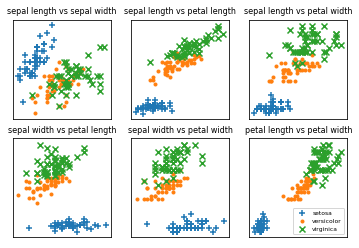

In [7]:
from matplotlib import pyplot as plt
metrics = ['sepal length', 'sepal width', 'petal length', 'petal width']
pairs = [(i, j) for i in range(4) for j in range(4) if i < j]
marks = ['+', '.', 'x']  # we have 3 classes, so 3 markers

fig, ax = plt.subplots(2, 3)

for row in range(2):
    for col in range(3):
        i, j = pairs[3 * row + col]
        ax[row][col].set_title(f"{metrics[i]} vs {metrics[j]}", fontsize=8)
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])

        for mark, (species, points) in zip(marks, points_by_species.items()):
            xs = [point[i] for point in points]
            ys = [point[j] for point in points]
            ax[row][col].scatter(xs, ys, marker=mark, label=species)

ax[-1][-1].legend(loc='lower right', prop={'size': 6});

# plt.show()
# plt.savefig('im/iris_scatter.png')
# plt.gca().clear()
    

In [8]:
import random
from scratch.machine_learning import split_data

random.seed(12)
iris_train, iris_test = split_data(iris_data, 0.70)
assert len(iris_train) == 0.7 * 150
assert len(iris_test) == 0.3 * 150

In [9]:
from typing import Tuple

# track how many times we see (predicted, actual)
confusion_matrix: Dict[Tuple[str, str], int] = defaultdict(int)
num_correct = 0

for iris in iris_test:
    predicted = knn_classify(5, iris_train, iris.point)
    actual = iris.label

    if predicted == actual:
        num_correct += 1

    confusion_matrix[(predicted, actual)] += 1

pct_correct = num_correct / len(iris_test)
print(pct_correct, confusion_matrix)

0.9777777777777777 defaultdict(<class 'int'>, {('setosa', 'setosa'): 13, ('versicolor', 'versicolor'): 15, ('virginica', 'virginica'): 16, ('virginica', 'versicolor'): 1})


In [10]:
import random

def random_point(dim: int) -> Vector:
    return [random.random() for _ in range(dim)]

def random_distances(dim: int, num_pairs: int) -> List[float]:
    return [distance(random_point(dim), random_point(dim))
            for _ in range(num_pairs)]

In [11]:
import tqdm
dimensions = range(1, 101)

avg_distances = []
min_distances = []

random.seed(0)
for dim in tqdm.tqdm(dimensions, desc="Curse of Dimensionality"):
    distances = random_distances(dim, 10000)      # 10,000 random pairs
    avg_distances.append(sum(distances) / 10000)  # track the average
    min_distances.append(min(distances))          # track the minimum

Curse of Dimensionality: 100%|██████████| 100/100 [00:25<00:00,  3.86it/s]


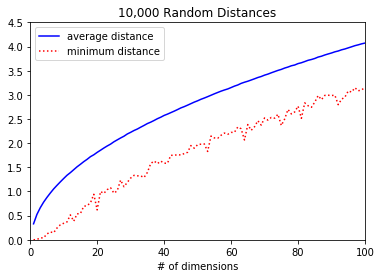

In [12]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(dimensions,avg_distances,ls='-',c='b',label='average distance')
ax.plot(dimensions,min_distances,ls=':',c='r',label='minimum distance');
ax.set_xlim(0,100);
ax.set_ylim(0,4.5);
ax.set_xlabel('# of dimensions');
ax.set_title('10,000 Random Distances');
ax.legend();

In [13]:
min_avg_ratio = [min_dist / avg_dist
                 for min_dist, avg_dist in zip(min_distances, avg_distances)]

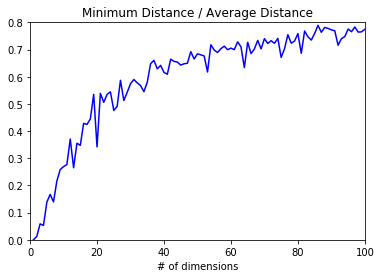

In [14]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(dimensions,min_avg_ratio,ls='-',c='b',label='min average distance')
ax.set_xlim(0,100);
ax.set_ylim(0,0.8);
ax.set_xlabel('# of dimensions');
ax.set_title('Minimum Distance / Average Distance');

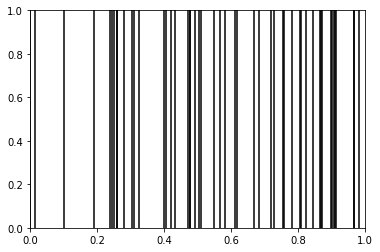

In [15]:
random.seed(0)
fig,ax = plt.subplots(1,1)
ax.vlines([random.random() for x in range(50)],0,1)
ax.set_xlim(0,1);ax.set_ylim(0,1);

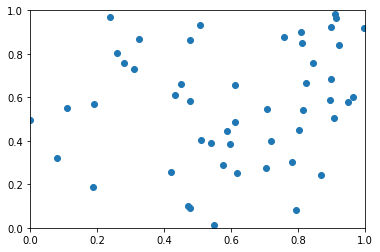

In [16]:
random.seed(0)
fig,ax = plt.subplots(1,1)
ax.scatter(*list(zip(*[(random.random(),random.random()) for x in range(50)])))
ax.set_xlim(0,1);ax.set_ylim(0,1);

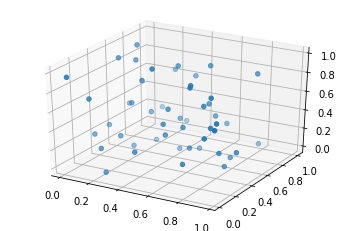

In [17]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*list(zip(*[(random.random(),random.random(),random.random()) for x in range(50)])));